In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imageio import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import median_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

sns.set_theme(style="darkgrid")

In [15]:
# Path to dataset
IMG_DIR = 'shipsnet'
class1 = []
class0 = []
for file in os.listdir(IMG_DIR):
    loaded_img = imread(os.path.join(IMG_DIR, file))
    if file[0] == '0':
        class0.append(loaded_img)
    else:
        class1.append(loaded_img)
class1 = np.array(class1)
class0 = np.array(class0)

print("Original Class0 and Class1 Shapes:")
print(f"Class 1 shape: {class1.shape}")
print(f"Class 0 shape: {class0.shape}")

# # downsampling class 0
# downsample_idx = np.random.choice(range(len(class0)), len(class1))
# class0 = class0[downsample_idx]

# print("Class0 and Class1 Shapes After Downsampling:")
# print(f"Class 1 shape: {class1.shape}")
# print(f"Class 0 shape: {class0.shape}")

/var/folders/z2/k1ddzt7d0q32_935myb4fz300000gn/T/ipykernel_26670/3586923687.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  loaded_img = imread(os.path.join(IMG_DIR, file))


Original Class0 and Class1 Shapes:
Class 1 shape: (1000, 80, 80, 3)
Class 0 shape: (3000, 80, 80, 3)


### Applying Median Filter & Visualizing Effects

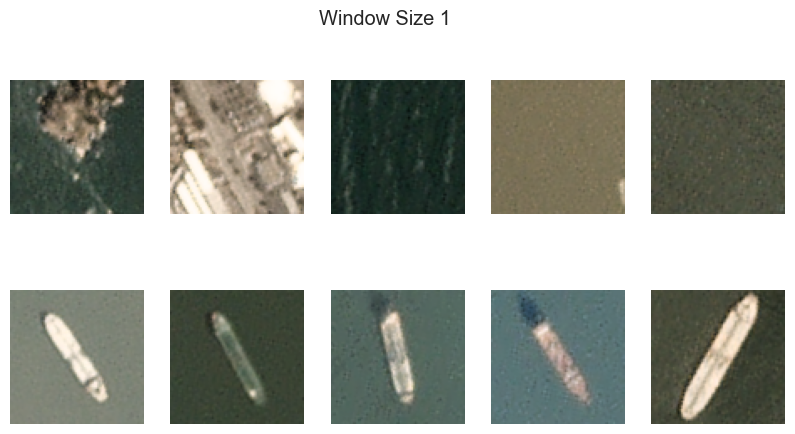

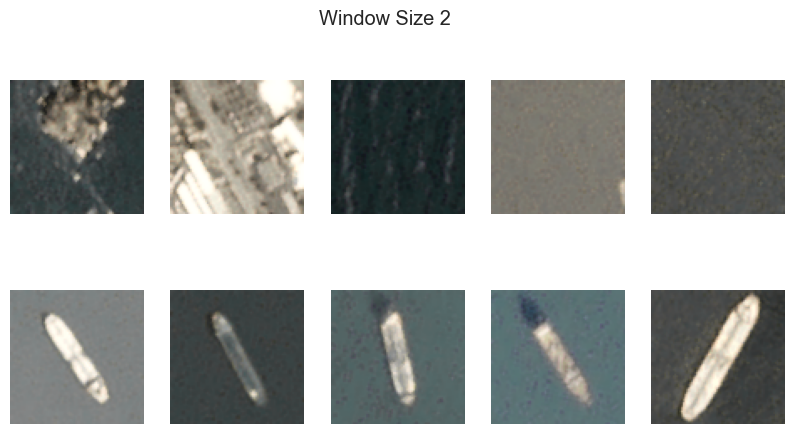

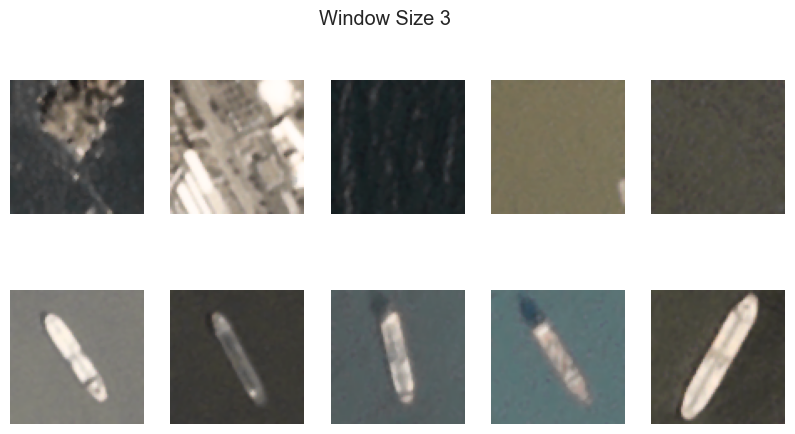

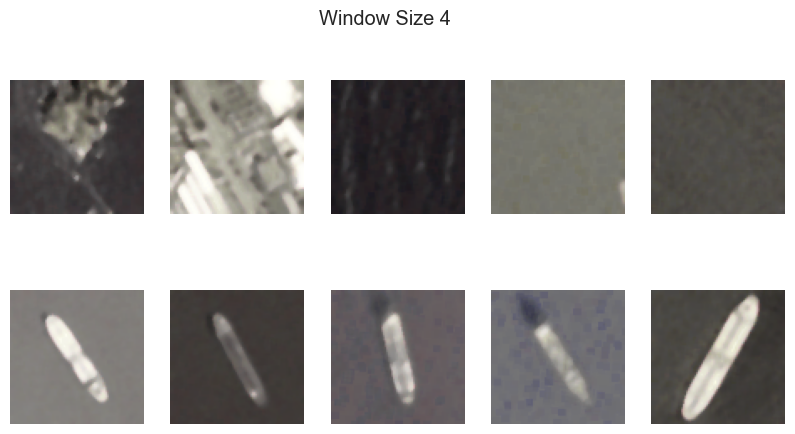

In [37]:
# Function to apply median filtering to images
def apply_median_filter(image, window_size=3): # Window size is set to 3.
    filtered_image = median_filter(image, size=window_size)
    return filtered_image

np.random.seed = 888
class0_sample = class0[np.random.choice(range(len(class0)), 5)]
class1_sample = class1[np.random.choice(range(len(class1)), 5)]

for window_size in [1, 2, 3, 4]:
    class0_sample_filtered = np.array([apply_median_filter(img, window_size) for img in class0_sample])
    class1_sample_filtered = np.array([apply_median_filter(img, window_size) for img in class1_sample])
    
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))

    for idx, img in enumerate(class0_sample_filtered):
        axs[0][idx].imshow(img)
        axs[0][idx].axis('off')

    for idx, img in enumerate(class1_sample_filtered):
        axs[1][idx].imshow(img)
        axs[1][idx].axis('off')
    plt.suptitle(f"Window Size {window_size}")
    plt.show()

In [38]:
# It looks like window size 3 does perform the best, so sticking with that

# Applying median filtering to images
class1_filtered = np.array([apply_median_filter(img, 3) for img in class1])
class0_filtered = np.array([apply_median_filter(img, 3) for img in class0])

### Splitting Data

In [39]:
# Concatenating filtered images
X = np.concatenate((class1_filtered, class0_filtered), axis=0)
y = np.concatenate((np.ones(class1.shape[0]), np.zeros(class0.shape[0])), axis=0)

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Normalizing pixel values to the range [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Baseline Model

In [40]:
# Flattening the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initializing and training the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test_flat)

# Calculating test accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.9525


### Data Augmentation

In [135]:
X_train[0].shape

def apply_random_contrast_saturation(img):
    img = tf.image.random_contrast(
        image = img, lower = 0.8, upper = 1.2, 
        seed = 888
    )
    img = tf.image.random_saturation(
        image = img, lower = 0.8, upper = 1.2,
        seed = 888)
    return img

apply_random_contrast_saturation(X_train[0])

<tf.Tensor: shape=(80, 80, 3), dtype=float64, numpy=
array([[[0.62872213, 0.53205657, 0.47169825],
        [0.61100328, 0.5348863 , 0.44576001],
        [0.59328443, 0.51716745, 0.44448   ],
        ...,
        [0.5507592 , 0.51162958, 0.40606445],
        [0.68187869, 0.57699364, 0.48786741],
        [0.70668507, 0.65522629, 0.5661    ]],

       [[0.62872213, 0.53616625, 0.47169825],
        [0.62517834, 0.53262252, 0.44349623],
        [0.60745949, 0.51490366, 0.44221622],
        ...,
        [0.60037196, 0.50781614, 0.44334811],
        [0.64644098, 0.57443368, 0.49352685],
        [0.68187869, 0.59754223, 0.5618422 ]],

       [[0.63580966, 0.53503442, 0.45412752],
        [0.63226587, 0.5356003 , 0.45880318],
        [0.61100328, 0.5348863 , 0.46219882],
        ...,
        [0.60037196, 0.5324744 , 0.44334811],
        [0.62872213, 0.55260515, 0.45936912],
        [0.63580966, 0.57613152, 0.49111494]],

       ...,

       [[0.56139052, 0.47705406, 0.40436664],
        [0.4905

In [154]:
# Data augmentation to improve generalization

# define preprocessing function to randomly adjust saturation and contrast
# these are not available by default in ImageDataGenerator
def apply_random_effects(img):
    img = tf.image.random_contrast(
        image = img, lower = 0.9, upper = 1.1, 
        seed = 888
    )
    img = tf.image.random_saturation(
        image = img, lower = 0.9, upper = 1.1,
        seed = 888)
    img = tf.image.random_brightness(
        image = img, max_delta = 0.1, seed = 888
    )
    return img

datagen = ImageDataGenerator(
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = apply_random_effects
)

datagen.fit(X_train)

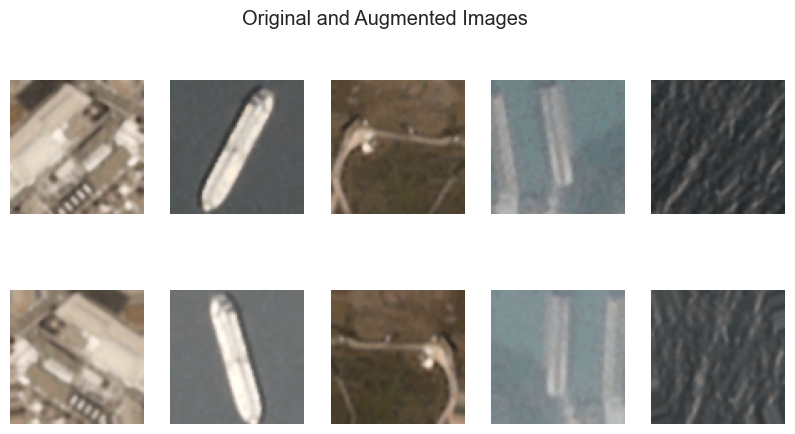

In [155]:
aug_imgs = datagen.flow(X_train[0:5], shuffle=False)[0]
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for idx, img in enumerate(X_train[0:5]):
    axs[0][idx].imshow(img)
    axs[0][idx].axis('off')

for idx, img in enumerate(aug_imgs):
    axs[1][idx].imshow(img)
    axs[1][idx].axis('off')
plt.suptitle(f"Original and Augmented Images")
plt.show()

### Modeling

Epoch 1/5


2024-03-19 19:33:48.011702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


75/75 [==============================] - 6s 75ms/step - loss: 0.5204 - accuracy: 0.7671 - val_loss: 0.4206 - val_accuracy: 0.8163
Epoch 2/5
75/75 [==============================] - 5s 72ms/step - loss: 0.3885 - accuracy: 0.8292 - val_loss: 0.4047 - val_accuracy: 0.8200
Epoch 3/5
75/75 [==============================] - 6s 74ms/step - loss: 0.3002 - accuracy: 0.8746 - val_loss: 0.2506 - val_accuracy: 0.8813
Epoch 4/5
75/75 [==============================] - 6s 84ms/step - loss: 0.2311 - accuracy: 0.9058 - val_loss: 0.2060 - val_accuracy: 0.9125
Epoch 5/5
25/25 [==============================] - 0s 18ms/step - loss: 0.1723 - accuracy: 0.9275
Test Accuracy: 0.9275000095367432


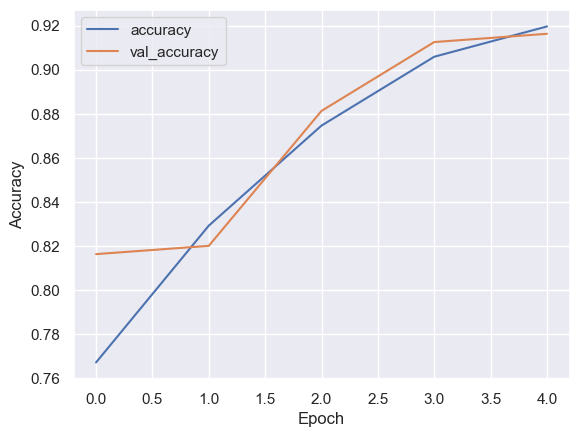

In [156]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot training history

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()